```python
from pandas import CategoricalDtype, read_csv, DataFrame
import pandas as pd
from math import floor, log10
from tensorflow.data import Dataset, AUTOTUNE
from pathlib import Path
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
import tensorflow as tf
from matplotlib.pyplot import figure, title, axis, imshow, show


def _1(_2):
    _3 = {_4: [] for _4 in _15}
    for _5 in _18:
        _6 = _2[_2['TEAM'] == _5]
        for _7, _8 in _19:
            for _ in range(_8 - sum(_6['ROLE'] == _7)):
                _3['TEAM'].append(_5)
                _3['ROLE'].append(_7)
                for _9 in _20:
                    _3[_9].append(0)
    return DataFrame(_3).astype(_15)


def _10(_11, _12):
    _13 = decode_png(read_file(_11), 1)[230:930, 530:1370]
    return resize(tf.concat(
        (_13[:, :40], _13[:, 390:420], _13[:, 450:480], _13[:, 500:530], _13[:, 570:640], _13[:, 670:740],
         _13[:, 770:]), 1), (400, 400), preserve_aspect_ratio=True) / 255, _12


_14 = 'DEFEAT', 'DRAW', 'VICTORY'
_15 = {'TEAM': 'uint8', 'ROLE': CategoricalDtype(('TANK', 'DAMAGE', 'SUPPORT')), 'E': 'uint8', 'A': 'uint8',
       'D': 'uint8', 'DMG': 'uint16', 'H': 'uint16', 'MIT': 'uint16'}
_16 = pd.concat((read_csv(f'ROLE/{_17}.csv', index_col=0, dtype=_15) for _17 in _14), keys=_14, names=('RESULT',))
_16.dropna(inplace=True)
_18 = 1, 2
_19 = ('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2)
_20 = [_21 for _21 in _15 if _21 not in {'TEAM', 'ROLE'}]
_22 = pd.concat([_16, _16.groupby(level=(0, 1), group_keys=True).apply(_1)])
_22.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)
_23 = DataFrame()
_23['TEAM'] = _22['TEAM'] - 1
_23['ROLE'] = _22['ROLE'].cat.codes.astype('uint8')
for _24 in _20:
    for _25 in range(floor(log10(_22[_24].max())), -1, -1):
        _23[f'{_24}{_25}'] = (_22[_24] // 10 ** _25 % 10).astype('uint8')
_26 = _23.to_numpy().reshape(-1, 230)
_27 = Dataset.from_tensor_slices((sorted(list(str(_28) for _28 in Path().rglob('*.png'))), _26)).map(_10,
                                                                                                     AUTOTUNE).shuffle(
    len(_26)).batch(32).prefetch(AUTOTUNE)
for _29, _30 in _27.take(1):
    figure(figsize=(6, 6))
    title(_30[0])
    axis('off')
    imshow(_29[0], cmap='gray')
    show()

In [1]:
from pandas import CategoricalDtype, read_csv
import pandas as pd

# =====================================================
# Constants
# =====================================================
RESULTS = ('DEFEAT', 'DRAW', 'VICTORY')
TEAM_ROLE_DTYPE = {
    'TEAM': 'uint8',
    'ROLE': CategoricalDtype(('TANK', 'DAMAGE', 'SUPPORT')),
    'E': 'uint8',  # Eliminations
    'A': 'uint8',  # Assists
    'D': 'uint8',  # Deaths
    'DMG': 'uint16',  # Damage
    'H': 'uint16',  # Healing
    'MIT': 'uint16'  # Mitigation
}

# =====================================================
# Load and Prepare CSV Data
# =====================================================
df_all = pd.concat(
    (read_csv(f'ROLE/{result}.csv', index_col=0, dtype=TEAM_ROLE_DTYPE)
     for result in RESULTS),
    keys=RESULTS,
    names=('RESULT',)
)
df_all

TEAM     ROLE   E   A  D   DMG     H   MIT
RESULT  INDEX                                            
DEFEAT  1         1     TANK   0   0  8  2947  1425  4611
        1         1   DAMAGE   1   0  3  1818     0   650
        1         1   DAMAGE   2   0  7  4735   487   308
        1         1  SUPPORT   1   0  3  2078  2748     0
        1         1  SUPPORT   1   1  3   269  5848   189
...             ...      ...  ..  .. ..   ...   ...   ...
VICTORY 466       2     TANK  17   3  8  7147   351  3898
        466       2   DAMAGE  19   0  9  6344     0   847
        466       2   DAMAGE  26   1  7  9108   150   165
        466       2  SUPPORT   7  22  6  2734  8985     0
        466       2  SUPPORT   5  11  9  1363  4738    45

[9013 rows x 8 columns]

In [2]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9013 entries, ('DEFEAT', np.int64(1)) to ('VICTORY', np.int64(466))
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   TEAM    9013 non-null   uint8   
 1   ROLE    9012 non-null   category
 2   E       9013 non-null   uint8   
 3   A       9013 non-null   uint8   
 4   D       9013 non-null   uint8   
 5   DMG     9013 non-null   uint16  
 6   H       9013 non-null   uint16  
 7   MIT     9013 non-null   uint16  
dtypes: category(1), uint16(3), uint8(4)
memory usage: 143.4+ KB


In [3]:
df_all['ROLE'].unique()

['TANK', 'DAMAGE', 'SUPPORT', NaN]
Categories (3, object): ['TANK', 'DAMAGE', 'SUPPORT']

In [4]:
# =====================================================
# Load and Prepare CSV Data
# =====================================================
df_all.dropna(inplace=True)
df_all['ROLE'].unique()

['TANK', 'DAMAGE', 'SUPPORT']
Categories (3, object): ['TANK', 'DAMAGE', 'SUPPORT']

In [5]:
df_all['TEAM'].value_counts()

TEAM
1    4528
2    4484
Name: count, dtype: int64

In [6]:
from pandas import DataFrame

# =====================================================
# Constants
# =====================================================
TEAMS = (1, 2)
ROLE_COUNTS = (('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2))
NUMERIC_STATS = [col for col in TEAM_ROLE_DTYPE if col not in {'TEAM', 'ROLE'}]


# =====================================================
# Functions
# =====================================================
def pad_missing_roles(df_team: DataFrame) -> DataFrame:
    """주어진 팀의 ROLE별 인원이 부족할 경우, 빈 행(0으로 채움)을 추가"""
    missing_rows = {col: [] for col in TEAM_ROLE_DTYPE}
    for team in TEAMS:
        team_df = df_team[df_team['TEAM'] == team]
        for role, expected_count in ROLE_COUNTS:
            current_count = sum(team_df['ROLE'] == role)
            for _ in range(expected_count - current_count):
                missing_rows['TEAM'].append(team)
                missing_rows['ROLE'].append(role)
                for stat in NUMERIC_STATS:
                    missing_rows[stat].append(0)
    return DataFrame(missing_rows).astype(TEAM_ROLE_DTYPE)


# =====================================================
# Load and Prepare CSV Data
# =====================================================
# 팀별 ROLE 수 보정
df_filled = pd.concat([
    df_all,
    df_all.groupby(level=(0, 1), group_keys=True).apply(pad_missing_roles)
])
df_filled

TEAM     ROLE  E  A  D   DMG     H   MIT
RESULT  INDEX                                          
DEFEAT  1         1     TANK  0  0  8  2947  1425  4611
        1         1   DAMAGE  1  0  3  1818     0   650
        1         1   DAMAGE  2  0  7  4735   487   308
        1         1  SUPPORT  1  0  3  2078  2748     0
        1         1  SUPPORT  1  1  3   269  5848   189
...             ...      ... .. .. ..   ...   ...   ...
VICTORY 396       2     TANK  0  0  0     0     0     0
        396       2   DAMAGE  0  0  0     0     0     0
        396       2   DAMAGE  0  0  0     0     0     0
        396       2  SUPPORT  0  0  0     0     0     0
        396       2  SUPPORT  0  0  0     0     0     0

[9080 rows x 8 columns]

In [7]:
df_filled['TEAM'].value_counts()

TEAM
1    4540
2    4540
Name: count, dtype: int64

In [8]:
# =====================================================
# Load and Prepare CSV Data
# =====================================================
df_filled.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)
df_filled

TEAM     ROLE   E   A  D   DMG     H   MIT
RESULT  INDEX                                            
DEFEAT  1         1     TANK   0   0  8  2947  1425  4611
        1         1   DAMAGE   1   0  3  1818     0   650
        1         1   DAMAGE   2   0  7  4735   487   308
        1         1  SUPPORT   1   0  3  2078  2748     0
        1         1  SUPPORT   1   1  3   269  5848   189
...             ...      ...  ..  .. ..   ...   ...   ...
VICTORY 466       2     TANK  17   3  8  7147   351  3898
        466       2   DAMAGE  19   0  9  6344     0   847
        466       2   DAMAGE  26   1  7  9108   150   165
        466       2  SUPPORT   7  22  6  2734  8985     0
        466       2  SUPPORT   5  11  9  1363  4738    45

[9080 rows x 8 columns]

In [9]:
from math import floor, log10

# =====================================================
# Numeric Encoding
# =====================================================
df_encoded = DataFrame()
df_encoded['TEAM'] = df_filled['TEAM'] - 1
df_encoded['ROLE'] = df_filled['ROLE'].cat.codes.astype('uint8')

# 각 스탯을 자리수별로 분리 (예: 123 → [3, 2, 1])
for stat in NUMERIC_STATS:
    max_digit = floor(log10(df_filled[stat].max()))
    for d in range(max_digit, -1, -1):
        df_encoded[f'{stat}{d}'] = (df_filled[stat] // 10 ** d % 10).astype('uint8')
df_encoded

TEAM  ROLE  E1  E0  A1  A0  D1  D0  DMG4  DMG3  ...  H4  H3  \
RESULT  INDEX                                                  ...           
DEFEAT  1         0     0   0   0   0   0   0   8     0     2  ...   0   1   
        1         0     1   0   1   0   0   0   3     0     1  ...   0   0   
        1         0     1   0   2   0   0   0   7     0     4  ...   0   0   
        1         0     2   0   1   0   0   0   3     0     2  ...   0   2   
        1         0     2   0   1   0   1   0   3     0     0  ...   0   5   
...             ...   ...  ..  ..  ..  ..  ..  ..   ...   ...  ...  ..  ..   
VICTORY 466       1     0   1   7   0   3   0   8     0     7  ...   0   0   
        466       1     1   1   9   0   0   0   9     0     6  ...   0   0   
        466       1     1   2   6   0   1   0   7     0     9  ...   0   0   
        466       1     2   0   7   2   2   0   6     0     2  ...   0   8   
        466       1     2   0   5   1   1   0   9     0     1  ...   0   4   

               H2  H1  H0  MIT4  MIT3  MIT2  MIT1  MIT0  
RESULT  INDEX                                            
DEFEAT  1       4   2   5     0     4     6     1     1  
        1       0   0   0     0     0     6     5     0  
        1       4   8   7     0     0     3     0     8  
        1       7   4   8     0     0     0     0     0  
        1       8   4   8     0     0     1     8     9  
...            ..  ..  ..   ...   ...   ...   ...   ...  
VICTORY 466     3   5   1     0     3     8     9     8  
        466     0   0   0     0     0     8     4     7  
        466     1   5   0     0     0     1     6     5  
        466     9   8   5     0     0     0     0     0  
        466     7   3   8     0     0     0     4     5  

[9080 rows x 23 columns]

In [10]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9080 entries, ('DEFEAT', np.int64(1)) to ('VICTORY', np.int64(466))
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TEAM    9080 non-null   uint8
 1   ROLE    9080 non-null   uint8
 2   E1      9080 non-null   uint8
 3   E0      9080 non-null   uint8
 4   A1      9080 non-null   uint8
 5   A0      9080 non-null   uint8
 6   D1      9080 non-null   uint8
 7   D0      9080 non-null   uint8
 8   DMG4    9080 non-null   uint8
 9   DMG3    9080 non-null   uint8
 10  DMG2    9080 non-null   uint8
 11  DMG1    9080 non-null   uint8
 12  DMG0    9080 non-null   uint8
 13  H4      9080 non-null   uint8
 14  H3      9080 non-null   uint8
 15  H2      9080 non-null   uint8
 16  H1      9080 non-null   uint8
 17  H0      9080 non-null   uint8
 18  MIT4    9080 non-null   uint8
 19  MIT3    9080 non-null   uint8
 20  MIT2    9080 non-null   uint8
 21  MIT1    9080 non-null   uint8
 22  MIT0

In [11]:
df_encoded.nunique()

TEAM     2
ROLE     3
E1       6
E0      10
A1       7
A0      10
D1       3
D0      10
DMG4     3
DMG3    10
DMG2    10
DMG1    10
DMG0    10
H4       3
H3      10
H2      10
H1      10
H0      10
MIT4     4
MIT3    10
MIT2    10
MIT1    10
MIT0    10
dtype: int64

In [99]:
# =====================================================
# Numeric Encoding
# =====================================================
# NumPy로 변환 (각 샘플은 230차원 벡터)
features = tuple(df_encoded.to_numpy().reshape(-1, 230).T)
len(features), len(features[0])

(230, 908)

In [100]:
from pathlib import Path

# =====================================================
# TensorFlow Dataset 구성
# =====================================================
image_paths = sorted(str(p) for p in Path().rglob('*.png'))
image_paths[:3], image_paths[-3:]

(['ROLE/DEFEAT/001.png', 'ROLE/DEFEAT/002.png', 'ROLE/DEFEAT/003.png'],
 ['ROLE/VICTORY/464.png', 'ROLE/VICTORY/465.png', 'ROLE/VICTORY/466.png'])

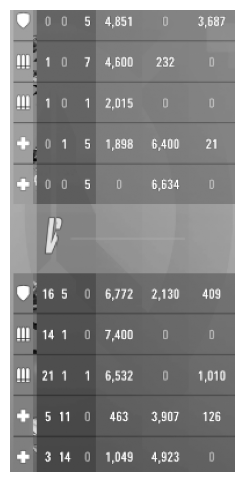

0 0 0 0 0 0 0 5 0 4 8 5 1 0 0 0 0 0 0 3 6 8 7 0 1 0 1 0 0 0 7 0 4 6 0 0 0 0 2 3 2 0 0 0 0 0 0 1 0 1 0 0 0 1 0 2 0 1 5 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 5 0 1 8 9 8 0 6 4 0 0 0 0 0 2 1 0 2 0 0 0 0 0 5 0 0 0 0 0 0 6 6 3 4 0 0 0 0 0 1 0 1 6 0 5 0 0 0 6 7 7 2 0 2 1 3 0 0 0 4 0 9 1 1 1 4 0 1 0 0 0 7 4 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 0 1 0 1 0 6 5 3 2 0 0 0 0 0 0 1 0 1 0 1 2 0 5 1 1 0 0 0 0 4 6 3 0 3 9 0 7 0 0 1 2 6 1 2 0 3 1 4 0 0 0 1 0 4 9 0 4 9 2 3 0 0 0 0 0


2025-10-31 13:03:11.065679: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [125]:
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
import tensorflow as tf
from matplotlib.pyplot import figure, axis, imshow, show

# =====================================================
# Constants
# =====================================================
X_SHAPE = (400, 400)

# =====================================================
# Functions
# =====================================================
def load_and_preprocess_image(image_path, label):
    """이미지를 로드하고 필요한 부분을 크롭 및 리사이즈"""
    image = decode_png(read_file(image_path), channels=1)[230:930, 530:1370]
    # 주요 구간을 추출 후 결합
    selected_regions = tf.concat([
        image[:, :40],
        image[:, 390:420],
        image[:, 450:480],
        image[:, 500:530],
        image[:, 570:640],
        image[:, 670:740],
        image[:, 770:]
    ], axis=1)
    return resize(selected_regions, X_SHAPE, preserve_aspect_ratio=True) / 255, label


# =====================================================
# TensorFlow Dataset 구성
# =====================================================
dataset = (
    Dataset.from_tensor_slices((image_paths, features))
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(len(features[0]))
    .batch(32)
    .prefetch(AUTOTUNE)
)

# =====================================================
# 샘플 시각화
# =====================================================
for images, labels in dataset.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(images[0], cmap='gray')
    show()
    print(*(label[0].numpy() for label in labels))

In [9]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
clear_session()
inputs = Input(X_SHAPE)
flatten = Flatten()(inputs)
dense_1 = Dense(300, 'relu')(flatten)
dense_2 = Dense(100, 'relu')(dense_1)
outputs = tuple(Dense(10, 'softmax', name=f'dense_3_{i}')(dense_2) for i in range(1, int_outputs + 1))
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 90000)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │ 27,000,300 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     30,100 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_1 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_2 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_3 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_4 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_5 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_6 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_7 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_8 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_9 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_10 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_11 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_12 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_13 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_14 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_15 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_16 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_17 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_18 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_19 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_20 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 27,242,500 (103.92 MB)

 Trainable params: 27,242,500 (103.92 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import Callback
from numpy import array


class Logger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f'Epoch {epoch + 1}/{self.params["epochs"]}' +
            f'\nloss: {logs["loss"]:.4f}' +
            f' - accuracy: {array([logs[f"dense_3_{i}_accuracy"] for i in range(1, int_outputs + 1)]).mean():.4f}' +
            f' - val_loss: {logs["val_loss"]:.4f}' +
            f' - val_accuracy: {array([logs[f"val_dense_3_{i}_accuracy"] for i in range(1, int_outputs + 1)]).mean():.4f}'
        )

In [28]:
model.compile('SGD', 'sparse_categorical_crossentropy', metrics=['accuracy'] * int_outputs)
history = model.fit(
    X_train,
    tuple_y_train,
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), Logger()),
    validation_data=(X_valid, tuple_y_valid)
)

2025-09-28 07:37:04.954034: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:04.963266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.198257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.235718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.237724: I extern

Epoch 1/1000
loss: 842547986432.0000 - accuracy: 0.2901 - val_loss: 461.0714 - val_accuracy: 0.3181
Epoch 2/1000
loss: 446.5577 - accuracy: 0.3421 - val_loss: 433.7435 - val_accuracy: 0.3571
Epoch 3/1000
loss: 402.9878 - accuracy: 0.3886 - val_loss: 373.7462 - val_accuracy: 0.4124
Epoch 4/1000
loss: 352.2129 - accuracy: 0.4315 - val_loss: 344.7107 - val_accuracy: 0.4248
Epoch 5/1000
loss: 335.7769 - accuracy: 0.4371 - val_loss: 337.0344 - val_accuracy: 0.4219
Epoch 6/1000
loss: 330.0737 - accuracy: 0.4389 - val_loss: 334.0575 - val_accuracy: 0.4181
Epoch 7/1000
loss: 327.5916 - accuracy: 0.4394 - val_loss: 332.8746 - val_accuracy: 0.4181
Epoch 8/1000
loss: 326.4442 - accuracy: 0.4395 - val_loss: 332.0260 - val_accuracy: 0.4190
Epoch 9/1000
loss: 325.8358 - accuracy: 0.4399 - val_loss: 331.3776 - val_accuracy: 0.4219
Epoch 10/1000
loss: 325.4693 - accuracy: 0.4393 - val_loss: 331.3204 - val_accuracy: 0.4181
Epoch 11/1000
loss: 325.2470 - accuracy: 0.4394 - val_loss: 331.2391 - val_accur

In [29]:
y_proba = array(model.predict(X_valid[:1])).argmax(2).reshape(10, 21)
y_proba

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[1, 6, 0, 3, 0, 5, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 1, 7, 2],
       [1, 2, 0, 0, 0, 6, 0, 7, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 8, 0, 9, 5, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 4, 0, 5, 0, 3, 1, 4, 0, 0, 8, 1, 7, 6, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 6, 0, 2, 0, 0, 0, 0, 5, 6, 3, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 2, 0, 5, 0, 0, 0, 9, 1, 0, 0, 0, 0, 0, 0, 5, 6, 3, 4],
       [1, 5, 0, 0, 0, 8, 0, 6, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 7, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 1, 8, 0, 5, 0, 3, 0, 0, 0, 0, 6, 4, 4, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 6, 0, 2, 0, 0, 0, 0, 6, 8, 7, 3, 0, 0, 0, 0, 0]])

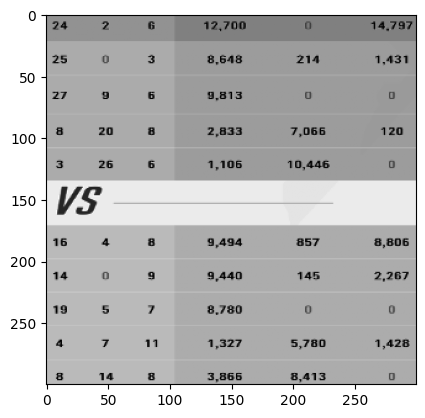

In [30]:
imshow(X_valid[0], 'binary')
show()

In [31]:
array(tuple_y_valid)[:, 0].reshape(10, 21)

array([[2, 4, 0, 2, 0, 6, 1, 2, 7, 0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 7],
       [2, 5, 0, 0, 0, 3, 0, 8, 6, 4, 8, 0, 0, 2, 1, 4, 0, 1, 4, 3, 1],
       [2, 7, 0, 9, 0, 6, 0, 9, 8, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 8, 2, 0, 0, 8, 0, 2, 8, 3, 3, 0, 7, 0, 6, 6, 0, 0, 1, 2, 0],
       [0, 3, 2, 6, 0, 6, 0, 1, 1, 0, 6, 1, 0, 4, 4, 6, 0, 0, 0, 0, 0],
       [1, 6, 0, 4, 0, 8, 0, 9, 4, 9, 4, 0, 0, 8, 5, 7, 0, 8, 8, 0, 6],
       [1, 4, 0, 0, 0, 9, 0, 9, 4, 4, 0, 0, 0, 1, 4, 5, 0, 2, 2, 6, 7],
       [1, 9, 0, 5, 0, 7, 0, 8, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 7, 1, 1, 0, 1, 3, 2, 7, 0, 5, 7, 8, 0, 0, 1, 4, 2, 8],
       [0, 8, 1, 4, 0, 8, 0, 3, 8, 6, 6, 0, 8, 4, 1, 3, 0, 0, 0, 0, 0]])

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout

clear_session()
input_ = Input(X_shape)
conv_2d_1 = Conv2D(64, 7, padding='same', activation='relu', kernel_initializer='HeNormal')(input_)
max_pool_2d_1 = MaxPool2D()(conv_2d_1)
conv_2d_2 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_1)
conv_2d_3 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_2)
max_pool_2d_2 = MaxPool2D()(conv_2d_3)
conv_2d_4 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_2)
conv_2d_5 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_4)
max_pool_2d_3 = MaxPool2D()(conv_2d_5)
flatten = Flatten()(max_pool_2d_3)
dense_1 = Dense(128, 'relu', kernel_initializer='HeNormal')(flatten)
dropout_1 = Dropout(.5)(dense_1)
dense_2 = Dense(64, 'relu', kernel_initializer='HeNormal')(dropout_1)
dropout_2 = Dropout(.5)(dense_2)
dense_3 = [Dense(10, 'softmax', name=f'dense_3_{i}')(dropout_2) for i in range(1, int_outputs + 1)]
model = Model(inputs=input_, outputs=dense_3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 150, 150,  │    147,584 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │    590,080 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 350464)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 44,859,520 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_1 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_2 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_3 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_4 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_5 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_6 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_7 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_8 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,240,308 (176.39 MB)

 Trainable params: 46,240,308 (176.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile('nadam', 'sparse_categorical_crossentropy', metrics=['accuracy'] * int_outputs)
history = model.fit(
    X_train,
    tuple_y_train,
    16,
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), Logger()),
    validation_data=(X_valid, tuple_y_valid)
)

Epoch 1/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 2/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 3/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 4/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 5/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 6/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 7/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 8/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 9/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 10/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 11/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543


F0000 00:00:1759046499.642028    7704 bfc_allocator.cc:719] Check failed: h != kInvalidChunkHandle 
